# Lab 5


## JMuBEN2 dataset


(https://data.mendeley.com/datasets/tgv3zb82nd/1)

Image dataset taken from an Arabica coffee plantation. The image dataset contains collection of healthy and miner coffee leaves.

We used the same dataset that we used in Lab 4.

# Loading and Spliting the dataset 

In [1]:
import os
import requests
import zipfile
import numpy as np

dataset_url = 'https://github.com/ishaqmarashy/DATALFS/raw/main/JMuBEN.zip'
dataset_dir = './JMuBEN'

# create directory for dataset if it does not exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
# append JMuBEN.zip to the end of the path (this is where we download the file to)
zip_file_path = os.path.join(dataset_dir, 'JMuBEN.zip')


# check if file is downloaded already
if not os.path.exists(zip_file_path):
    
    # file is not downloaded so fetch the file
    response = requests.get(dataset_url)
    
    # write file to storage which is recieved from the response
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)
        
    # unzip to zip file path
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

# within the concat train and test to become ./JMuBEN/train and JMuBEN ./JMuBEN/test
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [2]:
def load_images_and_labels(directory):
    images = []
    labels = []
    
    # get subdirectories Healthy and Miner
    
    for class_name in os.listdir(directory):
        
        # concat subdirectory to get full path
        class_dir = os.path.join(directory, class_name)
        # assign labels using class subdirectory
        # label is determined by filepath
        label = 0 if class_name == 'Miner' else 1
        
        # append labels and image paths to labels and images respectively
        for filename in os.listdir(class_dir):
            images.append(os.path.join(class_dir, filename))
            labels.append(label)
            
    return images, labels

# load file directories and their labels
train_images_dir, train_labels = load_images_and_labels(train_dir)
test_images_dir, test_labels = load_images_and_labels(test_dir)

In [3]:
# print the number of images and labels

print(f"Train images:{len(train_images_dir)}  Labels:{len(train_labels)}")
print(f"Test images:{len(test_images_dir)}  Labels:{len(test_labels)}")


Train images:24000  Labels:24000
Test images:6000  Labels:6000


# Pre-processing and Normalization

Images in the dataset were converted to grayscale and resized to 128x128

Tried loading as described https://www.analyticsvidhya.com/blog/2021/07/step-by-step-guide-for-image-classification-on-custom-datasets/

https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

In [6]:
import cv2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

def load_grayscale_images(image_paths):
    loaded_images = []
    for image_path in image_paths:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  #  grayscale
        loaded_images.append(img)
    return loaded_images

def resize_images(images_to_resize):
    resized_images = []
    for img in images_to_resize:
        resized_img = cv2.resize(img, (48, 48))  # resize
        resized_images.append(resized_img)
    return resized_images

def normalize_image(images_to_normalize):
    normalized_images = []
    for img in images_to_normalize:
        normalized_img = img / 255.0  # normalize
        normalized_images.append(normalized_img)
    return normalized_images

image_pipeline = Pipeline(steps=[
    ('load_grayscale_images', FunctionTransformer(load_grayscale_images)),
    ('resize_images', FunctionTransformer(resize_images)),
    ('normalize_image', FunctionTransformer(normalize_image))
])


train_images=image_pipeline.transform(train_images_dir)
test_images=image_pipeline.transform(test_images_dir)

In [7]:
print(len(train_images))
print(len(test_images))

24000
6000


# Model Training

In [8]:
x_train = train_images

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)

train_images = train_images.reshape(train_images.shape[0], -1)
train_labels = train_labels.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

### 1) Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf1 = MultinomialNB(alpha=1.0e-10, force_alpha=True , class_prior=[0.4, 0.6])
train_labels = train_labels.ravel()
clf1.fit(train_images, train_labels)
predictions1 = clf1.predict(test_images)

##### Model Evaluation


In [ ]:
from sklearn.metrics import accuracy_score

# accuracy
accuracy = accuracy_score(test_labels, predictions1)
print('Accuracy = ', accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions1)
confusion_matrix

In [ ]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

In [ ]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(test_labels, predictions1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions1)
print('Recall = ', recall)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate predicted probabilities for the positive class
probabilities = clf1.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 2) Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf2 = GaussianNB()
clf2.fit(train_images, train_labels)
predictions2 = clf2.predict(test_images)

##### Model Evaluation


In [ ]:
# accuracy
accuracy = accuracy_score(test_labels, predictions2)
print('Accuracy = ', accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions2)
confusion_matrix

In [ ]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

In [ ]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

In [ ]:
precision = precision_score(test_labels, predictions2)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions2)
print('Recall = ', recall)

In [ ]:
# Calculate predicted probabilities for the positive class
probabilities = clf2.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 3) Complement Naive Bayes

In [ ]:
from sklearn.naive_bayes import ComplementNB
clf3 = ComplementNB(force_alpha=True)
clf3.fit(train_images, train_labels)
predictions3 = clf3.predict(test_images)

##### Model Evaluation


In [ ]:
# accuracy
accuracy = accuracy_score(test_labels, predictions3)
print('Accuracy = ', accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions3)
confusion_matrix

In [ ]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

In [ ]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

In [ ]:
precision = precision_score(test_labels, predictions3)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions3)
print('Recall = ', recall)

In [ ]:
# Calculate predicted probabilities for the positive class
probabilities = clf3.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 4) Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf4 = BernoulliNB(force_alpha=True)
clf4.fit(train_images, train_labels)
predictions4 = clf4.predict(test_images)

##### Model Evaluation


In [ ]:
# accuracy
accuracy = accuracy_score(test_labels, predictions4)
print('Accuracy = ', accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions4)
confusion_matrix

In [ ]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

In [ ]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

In [ ]:
precision = precision_score(test_labels, predictions4, zero_division=1)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions4, zero_division=1)
print('Recall = ', recall)

In [ ]:
# Calculate predicted probabilities for the positive class
probabilities = clf4.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

### 5) Categorical Naive Bayes

In [ ]:
from sklearn.naive_bayes import CategoricalNB
clf5 = CategoricalNB(force_alpha=True)
clf5.fit(train_images, train_labels)
predictions5 = clf5.predict(test_images)

##### Model Evaluation


In [ ]:
# accuracy
accuracy = accuracy_score(test_labels, predictions5)
print('Accuracy = ', accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix
confusion_matrix = confusion_matrix(test_labels, predictions5)
confusion_matrix

In [ ]:
tp = confusion_matrix[0,0]
print("TP = ", tp)
fp = confusion_matrix[1,0]
print("FP = ", fp)
tn = confusion_matrix[1,1]
print("TN = ", tn)
fn = confusion_matrix[0,1]
print("FN = ", fn)

In [ ]:
sensitivity = tp / (tp + fn)
print('Sensitivity = ', sensitivity)

specificity = tn/ (fp + tn)
print('Specificity = ', specificity)

In [ ]:
precision = precision_score(test_labels, predictions5)
print('Precision = ', precision)

recall = recall_score(test_labels, predictions5)
print('Recall = ', recall)

In [ ]:
# Calculate predicted probabilities for the positive class
probabilities = clf5.predict_proba(test_images)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print("Area Under Curve = ", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
X=train_images

# Clustering


In [9]:
X=test_images
y=test_labels

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y, cluster_labels):
    cm = confusion_matrix(y, cluster_labels)
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    Sensitivity = TP / (TP + FN)
    Specificity = TN / (TN + FP)
    fpr= TP / (TP + FN)
    tpr= Sensitivity
    silhouette_scores = silhouette_score(X, cluster_labels)
    F1_score = f1_score(y, cluster_labels)
    roc_auc = roc_auc_score(y, cluster_labels)
    Precision = precision_score(y, cluster_labels)
    Recall = recall_score(y, cluster_labels)
    accuracy = accuracy_score(y, cluster_labels)

    return fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_scores

k_clusters=2
algorithms = [
    ('GM', GaussianMixture(n_components=k_clusters)),
    ('K-Means', KMeans(n_clusters=k_clusters, n_init="auto")),
    ('MiniBatchKMeans', MiniBatchKMeans(n_clusters=k_clusters, batch_size=1536 , init='k-means++', n_init=50)), 
    ('AgglomerativeClustering', AgglomerativeClustering(n_clusters=k_clusters))
]

def evaluate_unsupervised(algorithms,X):
    results = []
    for name, algorithm in algorithms:
        cluster_labels = algorithm.fit_predict(X)
        fpr, tpr, TP, FP, TN, FN, Sensitivity, Specificity, Precision, Recall, roc_auc, accuracy, F1_score, silhouette_score_ = calculate_metrics(y, cluster_labels)
        print(name,' Done')
        results.append({
            'Algorithm': name,
            'Silhouette Score': silhouette_score_,
            'TPR': tpr,
            'FPR': fpr,
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN,
            'Sensitivity': Sensitivity,
            'Specificity': Specificity,
            'Precision': Precision,
            'Recall': Recall,
            'ROC_AUC': roc_auc,
            'Accuracy': accuracy,
            'F1-Score': F1_score,
            f'Data {X.shape[1]} Features' : X,
            'algorithm':algorithm
        })
    return pd.DataFrame(results)


In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [13]:
results_df_full_feature = evaluate_unsupervised(algorithms,X)
results_df_full_feature

GM  Done
K-Means  Done


c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=6
  warnings.warn(


MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,Data 2304 Features,algorithm
0,GM,0.392455,0.466,0.466,1398,2169,831,1602,0.466,0.277000,0.391926,0.466,0.371500,0.371500,0.425765,"[[0.3764705882352941, 0.35294117647058826, 0.3...",GaussianMixture(n_components=2)
1,K-Means,0.393016,0.466,0.466,1398,2197,803,1602,0.466,0.267667,0.388873,0.466,0.366833,0.366833,0.423958,"[[0.3764705882352941, 0.35294117647058826, 0.3...","KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.393016,0.466,0.466,1398,2197,803,1602,0.466,0.267667,0.388873,0.466,0.366833,0.366833,0.423958,"[[0.3764705882352941, 0.35294117647058826, 0.3...","MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.383456,0.534,0.534,1602,515,2485,1398,0.534,0.828333,0.756731,0.534,0.681167,0.681167,0.626148,"[[0.3764705882352941, 0.35294117647058826, 0.3...",AgglomerativeClustering()


In [14]:
results_df_full_PCA= evaluate_unsupervised(algorithms,X_pca)
results_df_full_PCA

GM  Done
K-Means  Done


c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=6
  warnings.warn(


MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,Data 2 Features,algorithm
0,GM,0.336431,0.466,0.466,1398,2976,24,1602,0.466,0.008000,0.319616,0.466,0.237000,0.237000,0.379170,"[[3.027830916248536, 0.7855100105497704], [3.3...",GaussianMixture(n_components=2)
1,K-Means,0.393031,0.534,0.534,1602,795,2205,1398,0.534,0.735000,0.668335,0.534,0.634500,0.634500,0.593663,"[[3.027830916248536, 0.7855100105497704], [3.3...","KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.393031,0.466,0.466,1398,2205,795,1602,0.466,0.265000,0.388010,0.466,0.365500,0.365500,0.423444,"[[3.027830916248536, 0.7855100105497704], [3.3...","MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.384317,0.534,0.534,1602,506,2494,1398,0.534,0.831333,0.759962,0.534,0.682667,0.682667,0.627251,"[[3.027830916248536, 0.7855100105497704], [3.3...",AgglomerativeClustering()


In [15]:
results_df_full_tsne = evaluate_unsupervised(algorithms,X_tsne)
results_df_full_tsne

GM  Done
K-Means  Done


c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=6
  warnings.warn(


MiniBatchKMeans  Done
AgglomerativeClustering  Done


,Algorithm,Silhouette Score,TPR,FPR,TP,FP,TN,FN,Sensitivity,Specificity,Precision,Recall,ROC_AUC,Accuracy,F1-Score,Data 2 Features,algorithm
0,GM,0.034520,0.527333,0.527333,1582,1219,1781,1418,0.527333,0.593667,0.564798,0.527333,0.560500,0.560500,0.545423,"[[16.685333, 84.674614], [-10.9562435, 113.963...",GaussianMixture(n_components=2)
1,K-Means,0.026804,0.602333,0.602333,1807,1377,1623,1193,0.602333,0.541000,0.567525,0.602333,0.571667,0.571667,0.584411,"[[16.685333, 84.674614], [-10.9562435, 113.963...","KMeans(n_clusters=2, n_init='auto')"
2,MiniBatchKMeans,0.122851,0.353333,0.353333,1060,2159,841,1940,0.353333,0.280333,0.329295,0.353333,0.316833,0.316833,0.340891,"[[16.685333, 84.674614], [-10.9562435, 113.963...","MiniBatchKMeans(batch_size=1536, n_clusters=2,..."
3,AgglomerativeClustering,0.209443,0.222000,0.222000,666,1770,1230,2334,0.222000,0.410000,0.273399,0.222000,0.316000,0.316000,0.245033,"[[16.685333, 84.674614], [-10.9562435, 113.963...",AgglomerativeClustering()


## Hard Clustering


In [16]:
import pandas as pd
X_dataframe = pd.DataFrame(X)

In [17]:
X_dataframe.shape

(6000, 2304)

In [18]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=1,) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [19]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

In [20]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

In [21]:

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [22]:
from sklearn.cluster import KMeans
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
y_pred is kmeans.labels_

True

In [25]:
kmeans.cluster_centers_

array([[0.44181843, 0.43779978, 0.4385001 , ..., 0.41065314, 0.4121585 ,
        0.41281518],
       [0.62845053, 0.63679915, 0.6464979 , ..., 0.62168032, 0.6167217 ,
        0.61017977]])

In [26]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

### Original Dataset

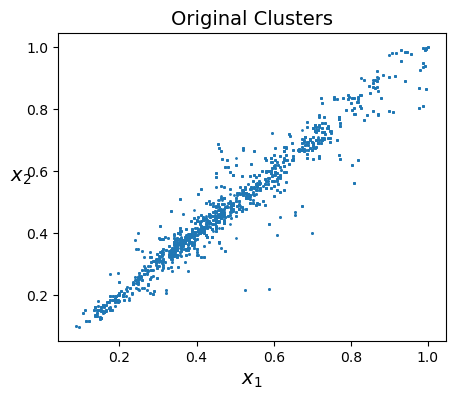

In [27]:
plt.figure(figsize=(5,4))
plt.title('Original Clusters', fontsize = 14)
plot_clusters(X)
plt.show()

### PCA reduced Dataset

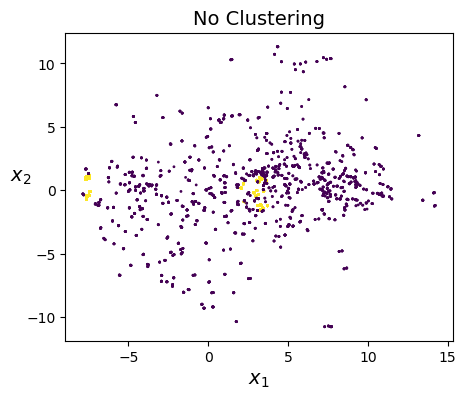

In [28]:
#No k-means applied on pca reduced dataset
plt.figure(figsize=(5,4))
plt.title('No Clustering', fontsize = 14)
plot_clusters(X_pca, y)
plt.show()

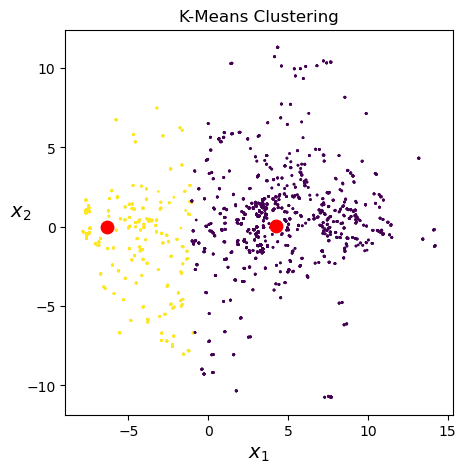

In [29]:

centroid_points = pca.transform(kmeans.cluster_centers_)
point1 = centroid_points[:, 0]
point2= centroid_points[:, 1]


#plotting the clusters and their centroids

plt.figure(figsize=(5, 5))
plt.title("K-Means Clustering")
plot_clusters(X_pca, y_pred)
plt.scatter(point1,point2 , c='red', s=80, marker='o')
plt.show()

In [30]:
kmeans_reduction_pca = KMeans(n_clusters=2, random_state=0).fit(X_pca)

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


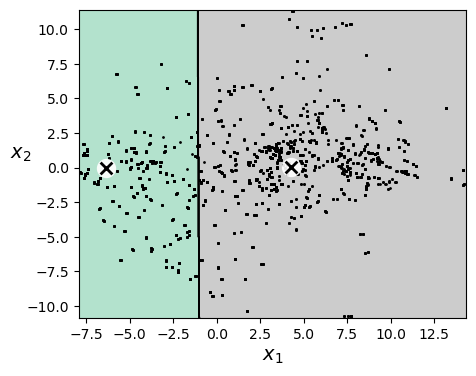

In [129]:
# plot decision boundary with reduced dataset
plt.figure(figsize=(5, 4))
plot_decision_boundaries(kmeans_reduction_pca, X_pca)
plt.show()

### TSNE

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


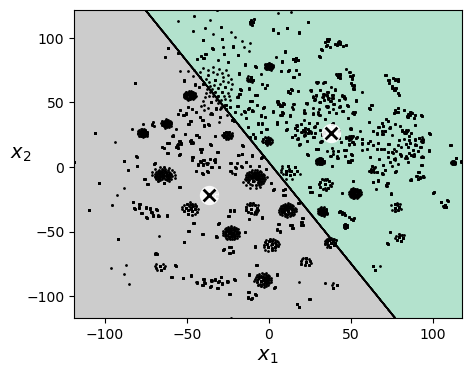

In [130]:
# plot decision boundary with reduced dataset  
plt.figure(figsize=(5, 4))
X_tsne = X_tsne.astype('float64')
kmeans_tsne_reduction = KMeans(n_clusters=2, random_state=0).fit(X_tsne)
plot_decision_boundaries(kmeans_tsne_reduction,X_tsne)
plt.show()

## Soft clustering


### Exploring different soft clustering algorithms

In [73]:

from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import OPTICS, cluster_optics_dbscan


ward_pca = AgglomerativeClustering(n_clusters=2).fit(X_pca)
kmeans_reduction_pca.transform(X_pca)
kmeans_miniBatch = MiniBatchKMeans(n_clusters=2)
kmeans_miniBatch.fit(X_pca)


c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(n_clusters=2)

#### DBSCAN

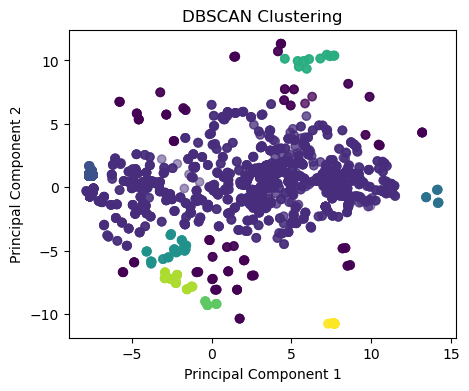

In [74]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


dbscan_model = DBSCAN(eps=1, min_samples=20)  
dbscan_model.fit(X_pca)


dbscan_labels = dbscan_model.labels_
plt.figure(figsize=(5, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


#### K-means, KMiniBatch, and Agglomerative Clustering

In [75]:

def scatter_plot(clusters, title):
    plt.title(title)
    for c in range(clusters.n_clusters):
        cluster = X_dataframe.iloc[clusters.labels_ == c]
        plt.scatter(cluster.iloc[:, 0], cluster.iloc[:, 1], label="Cluster " + str(c), alpha=0.1)
    plt.legend()

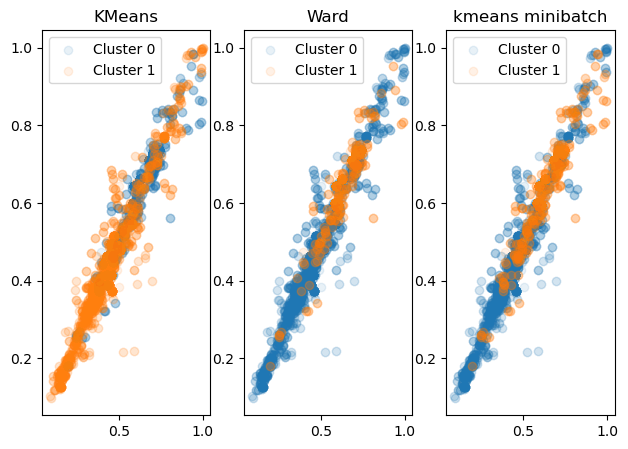

In [76]:
plt.figure(figsize=(10, 5))

plt.subplot(1,4,1)
scatter_plot(kmeans_reduction_pca, "KMeans")

plt.subplot(1,4,2)
scatter_plot(ward_pca, "Ward")

plt.subplot(1,4,3)
scatter_plot(kmeans_miniBatch, "kmeans minibatch")




#### GMM (Gaussian Mixture Models)

##### Referenced : https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#sphx-glr-auto-examples-mixture-plot-gmm-py

In [77]:
gaussianMixture = GaussianMixture(random_state=0)
gaussianMixture.fit(X_pca)

GaussianMixture(random_state=0)

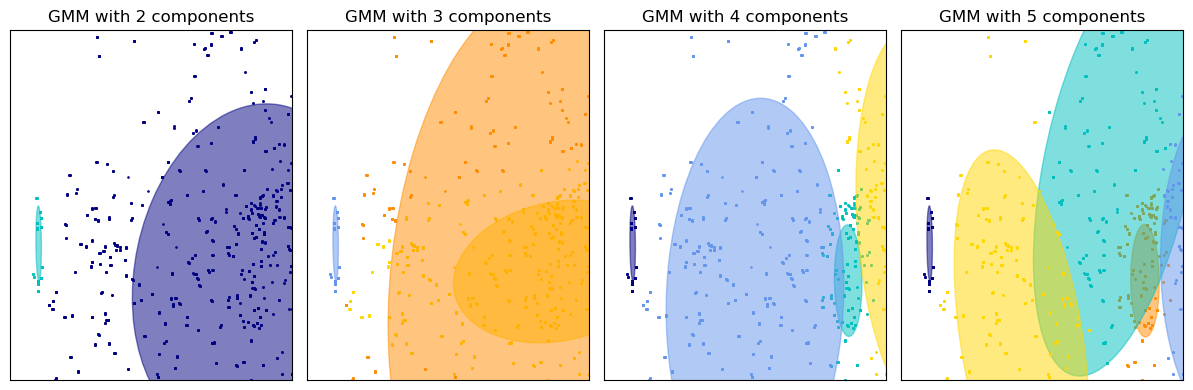

In [95]:
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import mixture

# Define your data X_pca before using it in the loop

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 5, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9.0, 5.0)
    plt.ylim(-3.0, 6.0)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

# Assuming X_pca is defined and contains your data

fig = plt.figure(figsize=(15, 4))  # Adjust figure size as needed

for i in range(2, 6):  # To plot 5 models with cluster numbers from 1 to 5
    gmm = mixture.GaussianMixture(n_components=i, covariance_type="full").fit(X_pca)
    plot_results(X_pca, gmm.predict(X_pca), gmm.means_, gmm.covariances_, i - 1, f"GMM with {i} components")

plt.tight_layout()
plt.show()


## Methods for finding Optimum Cluster Size

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


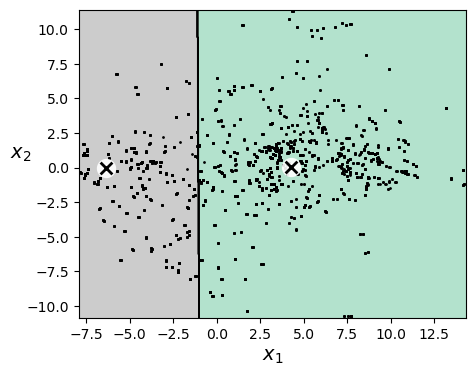

In [127]:
kmeans_rnd_10_inits_2_clusters = KMeans(n_clusters=2, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits_2_clusters.fit(X_pca)


plt.figure(figsize=(5, 4))
plot_decision_boundaries(kmeans_rnd_10_inits_2_clusters, X_pca)
plt.show()

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


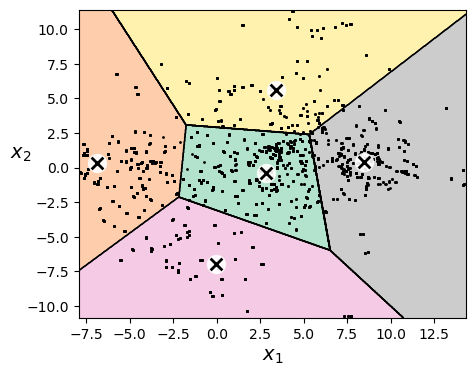

In [125]:
kmeans_rnd_10_inits_5_clusters = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits_5_clusters.fit(X_pca)

plt.figure(figsize=(5, 4))
plot_decision_boundaries(kmeans_rnd_10_inits_5_clusters, X_pca)
plt.show()

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


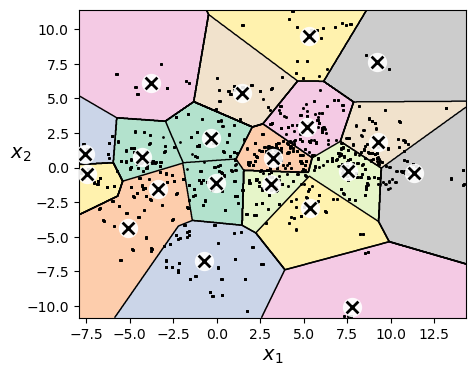

In [126]:
kmeans_rnd_10_inits = KMeans(n_clusters=20, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X_pca)

plt.figure(figsize=(5, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X_pca)
plt.show()

### Silhoutte Score

In [44]:

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-package

In [45]:
#referenced : tutorials
from sklearn.metrics import silhouette_score


In [46]:
silhouette_score(X, kmeans.labels_) 


0.39301551458305956

In [47]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k[1:]]     


C:\Users\Poornima\AppData\Local\Temp\ipykernel_29272\222064784.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2, 10), silhouette_scores, "bo-",color='green',linewidth=2)


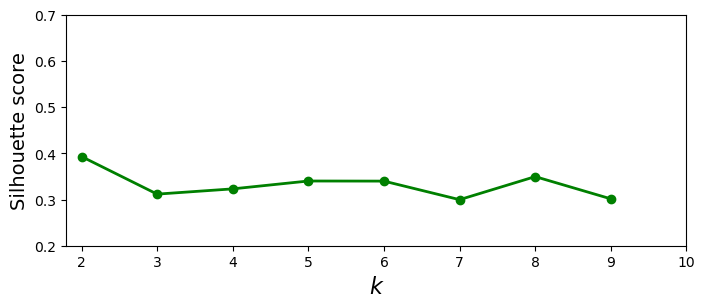

In [48]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-",color='green',linewidth=2)
plt.xlabel("$k$", fontsize=16)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 10, 0.20, 0.7])
plt.show()

### Elbow Method


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import sklearn

In [50]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-package

c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Poornima\anaconda3\lib\site-package

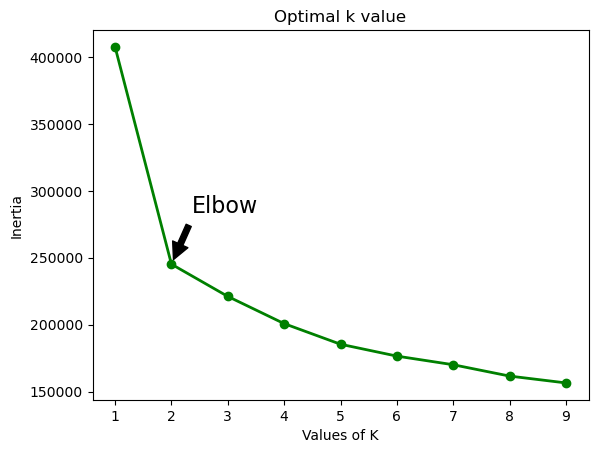

In [51]:
#reference : https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/
#reference : tutorials

data_frame = X_dataframe
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(data_frame)
 Sum_of_squared_distances.append(kmeans.inertia_)


plt.annotate('Elbow',
             xy=(2, inertias[1]), 
             xytext=(0.3, 0.5),  
             textcoords='figure fraction',  
             fontsize=16,  
             arrowprops=dict(facecolor='black', shrink=0.1)  
            )

plt.plot(K,Sum_of_squared_distances,"bo-",color="green",linewidth=2)
plt.xlabel("Values of K") 
plt.ylabel("Inertia") 
plt.title("Optimal k value")
plt.show()

### Cluster Validity (Calinski-Harabasz Index / Variance Ratio Index)

In [ ]:
# reference/credits - https://www.geeksforgeeks.org/calinski-harabasz-index-cluster-validity-indices-set-3/
#https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index


In [54]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

#Clustering performance evaluation - 
print("Variance Ratio Index", metrics.calinski_harabasz_score(X, y_pred))
print("David bouldin score", davies_bouldin_score(X, y_pred))



Variance Ratio Index 3973.9412468415653
David bouldin score 1.0088291727084546


### Similarity Measures

#### Chi-Square

In [131]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

X_new = SelectKBest(chi2, k=20).fit_transform(X, y)
X_new.shape


(6000, 20)